Purpose: Take in the resampled and synced force plate data and threshold to create ground truth gait event labels (heel strike and toe off). Append the ground truth labels to exoskeleton sensor data file. The exoskeleton sensor data file will be used to train the classification model. 

In [1]:
# Imports
import pandas as pd
import numpy as np
import os
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

Read and Filter Ground Reaction Force Plates

In [ ]:
# Read in data
fp_filepath = r'dir\fp_synced.csv'
# print(os.path.exists(fp_filepath))
fp = pd.read_csv(fp_filepath)
data = fp.iloc[:, 1:].values
# print(data)

In [3]:
# Filter Data - 4th order Butterworth
Fs = 75
Fc = 20
order = 4

Wn = Fc/(Fs/2)
b, a = butter(order, Wn, btype='low')

filtered_data = np.zeros_like(data)

for i in range(data.shape[1]):
    filtered_data[:, i] = filtfilt(b, a, data[:, i])

print(filtered_data)
fp.iloc[:, 1:] = filtered_data
fzR = fp['FzR'].values
fzL = fp['FzL'].values

[[ 6.10298831e-02  2.96112146e-02  5.77799912e-01 ...  1.61549135e-03
  -9.95478215e-03  5.29570162e+00]
 [ 5.07952822e-02  1.38026127e-02  5.78240107e-01 ...  2.58458710e-03
  -1.01572606e-02  5.29591654e+00]
 [ 4.81980424e-02  7.16012174e-03  5.79327546e-01 ...  3.65878416e-03
  -7.79940441e-03  5.29580288e+00]
 ...
 [ 6.95729913e-02  3.25979407e-02  6.02287870e-01 ... -6.79337745e-03
   1.74550828e-02  5.29579755e+00]
 [ 7.01000411e-02  2.53482004e-02  6.00274533e-01 ... -5.75854231e-03
   1.20837002e-02  5.29583441e+00]
 [ 7.43488844e-02  2.03102374e-02  5.92701632e-01 ...  3.41874315e-03
   9.31942950e-03  5.29545596e+00]]


Find Local Minima (in thresholded window) -> Set Toe-off and Heel-Strike Events

In [4]:
# Right Leg - Event Labels

low_threshold = 0.07
below_thresh_R = fzR < low_threshold

r_low = np.diff(np.concatenate(([0], below_thresh_R.astype(int), [0])))
starts_R = np.where(r_low == 1)[0]
ends_R = np.where(r_low == -1)[0] - 1

loc_to_R = []
loc_hs_R = []

# find minima within window
for start, end in zip(starts_R, ends_R):
    window = fzR[start:end+1]
    peaks, _ = find_peaks(-window)
    if len(peaks) > 0:
        loc_to_R.append(start + peaks[0]) # first minimum in window = TO
        loc_hs_R.append(start + peaks[-1]) # last minimum in window = HS
    else:
        loc_to_R.append(start)
        loc_hs_R.append(end)

# Left Leg - Event Labels
below_thresh_L = fzL < low_threshold # determine minimum threshold
l_low = np.diff(np.concatenate(([0], below_thresh_L.astype(int), [0])))
starts_L = np.where(l_low == 1)[0]
ends_L = np.where(l_low == -1)[0] - 1

loc_to_L = []
loc_hs_L = []

# find minima within window
for start, end in zip(starts_L, ends_L): 
    window = fzL[start:end+1]
    peaks, _ = find_peaks(-window)
    if len(peaks) > 0:
        loc_to_L.append(start + peaks[0]) # first minimum in window = TO
        loc_hs_L.append(start + peaks[-1]) # last minimum in window = HS
    else:
        loc_to_L.append(start)
        loc_hs_L.append(end)


Plot to Inspect the Gait Event Labeling

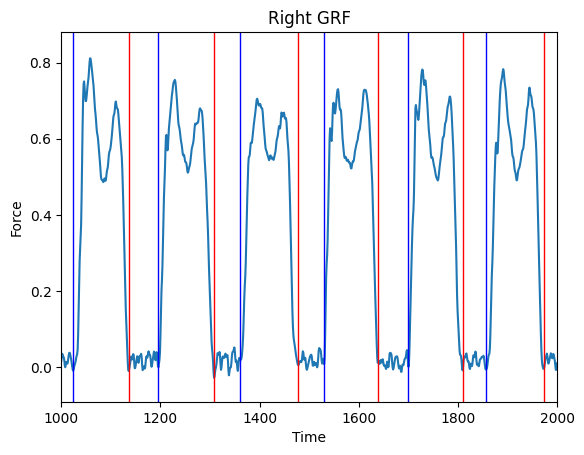

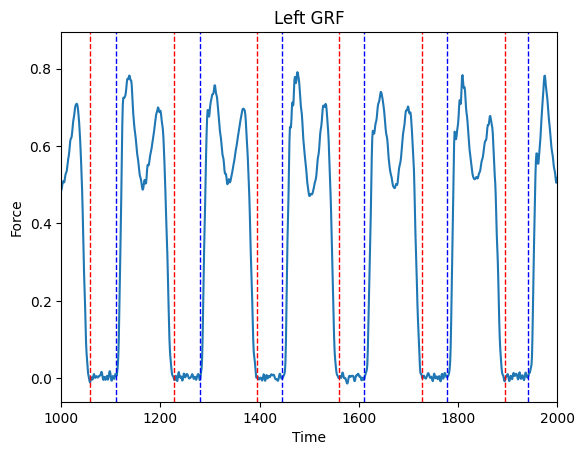

In [ ]:
# Right GRF Plot
plt.figure()
plt.plot(fzR, label='FzR')
for x in loc_to_R:
    plt.axvline(x, color='r', linewidth=1)
for x in loc_hs_R:
    plt.axvline(x, color='b', linewidth=1)
plt.title("Right GRF")
plt.xlabel("Time")
plt.ylabel("Force")
plt.xlim(1000,2000) # zoomed in to verify accuracy of markers
plt.show()

# Left GRF Plot
plt.figure()
plt.plot(fzL, label='FzL')
for x in loc_to_L:
    plt.axvline(x, color='r', linestyle='--', linewidth=1)
for x in loc_hs_L:
    plt.axvline(x, color='b', linestyle='--', linewidth=1)
plt.title("Left GRF")
plt.xlabel("Time")
plt.ylabel("Force")
plt.xlim(1000,2000) # zoomed in to verify accuracy of markers
plt.show()

Save Labels to Full Exoskeleton Sensor Data File

In [ ]:
exo_filepath = r'dir\exo_synced.csv'
exo = pd.read_csv(exo_filepath)

R_events = np.zeros(len(exo), dtype = int)
L_events = np.zeros(len(exo), dtype = int)

R_events[loc_to_R] = 1
R_events[loc_hs_R] = 2

L_events[loc_to_L] = 1
L_events[loc_hs_L] = 2

exo['R_events'] = R_events
exo['L_events'] = L_events

exo.to_csv(r'dir\exo_all_data_labeled.csv', index=False)